In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-02-12 22:22:00.330237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 22:22:00.589502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-12 22:22:00.589552: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-12 22:22:02.201629: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
funds = [{'fund_cd': '2008010903', 'fund_name': 'SMT TOPIXインデックス･オープン', 'asset_class': '国内株式'}, 
        {'fund_cd': '2008010904', 'fund_name': 'SMT グローバル株式インデックス', 'asset_class': '先進国株式'},
        {'fund_cd': '2008040102', 'fund_name': 'インデックスF海外新興国株式', 'asset_class': '新興国株式'},
        {'fund_cd': '2008010905', 'fund_name': 'SMT 国内債券インデックス･オープン', 'asset_class': '国内債券'},
        {'fund_cd': '2008010906', 'fund_name': 'SMT グローバル債券インデックス', 'asset_class': '先進国債券'},
        {'fund_cd': '2008040103', 'fund_name': 'インデックスF海外新興国債券(1年決算型)', 'asset_class': '新興国債券'}, 
        {'fund_cd': '2008010907', 'fund_name': 'SMT J-REITインデックス･オープン', 'asset_class': '国内リート'},
        {'fund_cd': '2008010908', 'fund_name': 'SMT グローバルREITインデックス', 'asset_class': '先進国リート'}
       ]

In [3]:
fundsdata = pd.read_csv('csv/'+funds[0]['fund_cd']+'.csv')
fundsdata = fundsdata.drop('基準価額', axis=1)
for fund in funds:
    df = pd.read_csv('csv/'+fund['fund_cd']+'.csv')
    df = df.rename(columns={'基準価額': fund['asset_class']})
    fundsdata = pd.merge(fundsdata, df, on='日付')
fundsdata.columns = ['date','jp_stock','foreign_stock','emerging_stock','jp_bond','foreign_bond','emerging_bond','jp_reit','foreign_reit']

In [4]:
# 2008~2019年をテストデータにする
funds_test = fundsdata.query('date < 20200101')
funds_dif = funds_test[ ['jp_stock','foreign_stock','emerging_stock','jp_bond','foreign_bond','emerging_bond','jp_reit','foreign_reit'] ]
funds_dif = np.log(funds_dif)-np.log(funds_dif.shift(1))
funds_dif = funds_dif.loc[1:]

In [5]:
# ウィンドウ区間の変化率をndarrayに変換
w=32
xlist = []
for i in range(len(funds_dif.index) - w):
    xlist.append(funds_dif.loc[i+1:i+w].values)

In [6]:
x_test = np.stack(xlist,0)

In [7]:
# サンプリング層
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
# VAEエンコーダ部分
latent_dim = 2

encoder_inputs = keras.Input(shape=(w, 8, 1))
x = layers.Conv2D(32, (3,3), activation="softplus", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, (3,3), activation="softplus", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="softplus")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

2023-02-12 22:23:56.009979: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-12 22:23:56.010099: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-12 22:23:56.010245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-UBLLJ3A): /proc/driver/nvidia/version does not exist
2023-02-12 22:23:56.010966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 8, 1)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 4, 32)    320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 2, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 1024)         0           ['conv2d_1[0][0]']               
                                                                                            

In [9]:
# VAEデコーダ部分
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 2 * 64, activation="softplus")(latent_inputs)
x = layers.Reshape((8, 2, 64))(x)
x = layers.Conv2DTranspose(64, (3,3), activation="softplus", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, (3,3), activation="softplus", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, (5,1), activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              3072      
                                                                 
 reshape (Reshape)           (None, 8, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 4, 64)        36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 8, 32)        18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 8, 1)         161 

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def predict(self, x):
        z_mean, _, _ = self.encoder.predict(x)
        y = self.decoder.predict(z_mean)
        return y

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [11]:

data = np.expand_dims(x_test,-1)

In [12]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(data, epochs=50, batch_size=128)

Epoch 1/50
23/23 [==============================] - 7s 67ms/step - loss: 80.8734 - reconstruction_loss: 32.1376 - kl_loss: 0.4623
Epoch 2/50
23/23 [==============================] - 1s 62ms/step - loss: 0.5259 - reconstruction_loss: 0.5316 - kl_loss: 0.0014
Epoch 3/50
23/23 [==============================] - 1s 58ms/step - loss: 0.5579 - reconstruction_loss: 0.5921 - kl_loss: 4.5856e-04
Epoch 4/50
23/23 [==============================] - 1s 62ms/step - loss: 0.6234 - reconstruction_loss: 0.5130 - kl_loss: 1.5075e-04
Epoch 5/50
23/23 [==============================] - 1s 60ms/step - loss: 0.6614 - reconstruction_loss: 0.5500 - kl_loss: 5.1313e-05
Epoch 6/50
23/23 [==============================] - 1s 64ms/step - loss: 0.4867 - reconstruction_loss: 0.5425 - kl_loss: 1.6741e-05
Epoch 7/50
23/23 [==============================] - 1s 65ms/step - loss: 0.4393 - reconstruction_loss: 0.5239 - kl_loss: 5.0693e-06
Epoch 8/50
23/23 [==============================] - 2s 67ms/step - loss: 0.4703 - 

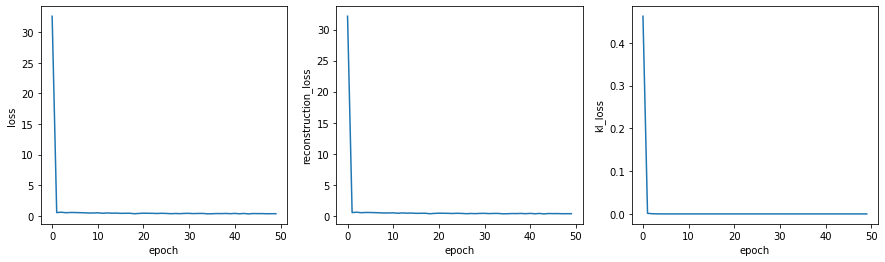

In [13]:
row = 1
col = 3
fig, ax = plt.subplots(row, col, figsize=(15,4))
ax[0].plot(history.history["loss"])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history["reconstruction_loss"])
ax[1].set_ylabel('reconstruction_loss')
ax[1].set_xlabel('epoch')
ax[2].plot(history.history["kl_loss"])
ax[2].set_ylabel('kl_loss')
ax[2].set_xlabel('epoch')
plt.show()

In [27]:
# 2022年以降を検証データにする
funds_valid= fundsdata.query('date >= 20200101 and date < 20230101')
valid_dif = funds_valid[ ['jp_stock','foreign_stock','emerging_stock','jp_bond','foreign_bond','emerging_bond','jp_reit','foreign_reit'] ]
valid_dif.reset_index(inplace=True, drop=True)
valid_dif = np.log(valid_dif)-np.log(valid_dif.shift(1))
valid_dif = valid_dif.loc[1:]

In [51]:
# ウィンドウ区間の変化率をndarrayに変換
vlist = []
for i in range(len(valid_dif.index) - w + 1):
    vlist.append(valid_dif.loc[i+1:i+w].values)

In [52]:
x_valid = np.stack(vlist,0)

In [53]:
x_input = np.expand_dims(x_valid,-1)
x_decode = vae.predict(x_input)

22/22 [==============================] - 0s 17ms/step


In [54]:
x_decode[230,1,:,:]

array([[3.66568100e-04],
       [4.26957326e-04],
       [1.16234914e-04],
       [2.72120902e-04],
       [6.53656462e-05],
       [1.67356469e-04],
       [2.20115558e-04],
       [3.43277236e-04]], dtype=float32)

In [32]:
x_input[230,1,:,:]

array([[ 0.00267926],
       [ 0.00596847],
       [-0.00170748],
       [-0.00058717],
       [-0.00438796],
       [ 0.00049221],
       [ 0.00941467],
       [ 0.01573646]])

In [55]:
x_input=x_input.squeeze()
x_decode=x_decode.squeeze()


    

In [39]:
x_1=x_input[1,:,:].squeeze()
x_2=x_decode[1,:,:].squeeze()
n_dif=np.sum((x_1-x_2)**2).sum()
print(n_dif)

0.021767115092859876


In [56]:
difs = funds_valid[['date']]
difs['dif'] = 0
difs.reset_index(inplace=True, drop=True)

/tmp/ipykernel_24567/530998421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  difs['dif'] = 0


In [57]:
for i in range(len(x_input)):
    vi = x_input[i,:,:].squeeze()
    vd = x_decode[i,:,:].squeeze()
    d = np.sum((vi-vd)**2).sum()
    difs.iloc[w+i,1] = d

In [58]:
difs.to_csv('difs.csv')